In [2]:
library(tidyverse)
library(ggplot2)
library(dplyr)
library(patchwork)
library(cowplot)

library(rhdf5)

library(infercnv)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘patchwork’ was built under R version 4.1.3”

Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
library(Seurat)

Attaching SeuratObject



In [4]:
library(Matrix)


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [5]:
source('function_single_cell_conversion.R')

#### h5

In [6]:
getwd()

[1] "/fast/work/projects/scCRC_Patients/scitcem/script_new_preprocessing"

In [7]:
adata = H5Fopen("../datasets_new_preprocessing/202305_CB_epi_cells.h5")

In [8]:
sobj = read_scanpy_h5('../datasets_new_preprocessing/202305_CB_epi_cells.h5',
                           if_pca = TRUE, if_umap = TRUE, if_CB_counts=TRUE, if_raw_counts=FALSE)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from raw_counts_ to rawcounts_”


In [9]:
Assays(sobj)

[1] "RNA"        "raw_counts"

In [10]:
sobj

An object of class Seurat 
59282 features across 39168 samples within 2 assays 
Active assay: RNA (29641 features, 0 variable features)
 1 other assay present: raw_counts
 2 dimensional reductions calculated: pca, umap

#### inferCNV

In [11]:
cnv_obj = readRDS('../datasets_new_preprocessing/inferCNV/run.final.infercnv_obj')

In [12]:
# long format: cell, gene, expression level
infercnv_expression = as.data.frame(cnv_obj@expr.data) %>% 
tibble::rownames_to_column(var = 'gene') %>% 
gather(key = 'cell', value = 'expression',-gene)

In [13]:
dim(infercnv_expression)

[1] 359209728         3

In [14]:
head(infercnv_expression)

,gene,cell,expression
,<chr>,<chr>,<dbl>
1,NOC2L,p020n:CATCGGGTCATGACAC,0.9231201
2,HES4,p020n:CATCGGGTCATGACAC,0.9237393
3,ISG15,p020n:CATCGGGTCATGACAC,0.9243582
4,AGRN,p020n:CATCGGGTCATGACAC,0.9260257
5,C1orf159,p020n:CATCGGGTCATGACAC,0.9278186
6,SDF4,p020n:CATCGGGTCATGACAC,0.9295308


In [15]:
gene_loc_table = as.data.frame(cnv_obj@gene_order) %>% tibble::rownames_to_column(var = 'gene')

In [16]:
dim(gene_loc_table)

[1] 9171    4

In [17]:
head(gene_loc_table)

,gene,chr,start,stop
,<chr>,<fct>,<int>,<dbl>
1,NOC2L,1,944204,959309
2,HES4,1,998962,1000172
3,ISG15,1,1001138,1014541
4,AGRN,1,1020123,1056118
5,C1orf159,1,1081818,1116361
6,SDF4,1,1216908,1232031


### tree
using Florian's code: https://itbgit.biologie.hu-berlin.de/uhlitz/sccrc/-/blob/master/_src/infercnv.R

seu_epi_final <- read_rds("../datasets/anno/CRC/3p/seu_epi_final.rds")

In [18]:
# I think pid = patient id
pids = c('p020t', 'p021t', 'p007t', 'p008t', 'p009t1', 'p009t2', 'p013t', 'p014t', 'p016t', 'p026t', 'p035t')

In [19]:
dendro_lines <- read_lines("../datasets_new_preprocessing/inferCNV/infercnv.observations_dendrogram.txt")

#### the order of sample != order in the dendro list..... 
lapply(dendro_lines, function(x) phylogram::read.dendrogram(text = x)) %>% 
       lapply(function(x) enframe(dendextend::cutree(x, k = 2), "cell_id", "clone"))

In [20]:
dendro_list <- lapply(dendro_lines, function(x) phylogram::read.dendrogram(text = x)) %>% setNames(pids)
cell_order <- lapply(dendro_lines, function(x) str_split(x, "\\(|:|,|\\)") %>% unlist %>% .[str_detect(., "p0")]) %>% unlist

In [21]:
# reference cells
epi_anno = read.csv2('../datasets_new_preprocessing/all_epi_cell_anno.txt', sep = ' ')

In [22]:
epi_anno_normal = epi_anno %>% tibble::rownames_to_column(var = 'cell_id') %>% 
filter(str_detect(cell_id, 'n')) %>% mutate(clone  = 'Normal', sample = gsub(':.*', '', cell_id))
epi_anno_normal

cell_id,celltype_1a,clone,sample
<chr>,<chr>,<chr>,<chr>
p020n:CATCGGGTCATGACAC,epi,Normal,p020n
p020n:ACGTCCTAGGCACTAG,epi,Normal,p020n
p020n:CAGCGTGGTTGCCATA,epi,Normal,p020n
p020n:AAACCCACAAGTTGGG,epi,Normal,p020n
p020n:CATGGATGTTCGTAAC,epi,Normal,p020n
p020n:CAGCAATCAGATGCGA,epi,Normal,p020n
p020n:GTCTGTCGTGCCTGCA,epi,Normal,p020n
p020n:GTGCAGCTCCATAGAC,epi,Normal,p020n
p020n:ACCTACCTCAGACCGC,epi,Normal,p020n


In [23]:
# cut the tree and put the reference cells back
clone_table = lapply(dendro_list, function(x) enframe(dendextend::cutree(x, k = 2), "cell_id", "clone")) %>% 
       bind_rows(.id = 'sample') %>%
       mutate(clone = as.character(clone)) %>% 
       mutate(cell_id = str_replace_all(cell_id, '-', ':')) %>% 
       bind_rows(epi_anno_normal[c('sample','cell_id', 'clone')]
                )
       

Registered S3 method overwritten by 'dendextend':
  method              from     
  as.dendrogram.phylo phylogram



In [24]:
head(clone_table)

sample,cell_id,clone
<chr>,<chr>,<chr>
p020t,p020t:GACCGTGTCTGAGGTT,1
p020t,p020t:TAGGTTGGTCGCATCG,1
p020t,p020t:CCGGTGAAGATGATTG,1
p020t,p020t:GCAACCGGTGACGCCT,1
p020t,p020t:TTCCGGTAGATGACAT,1
p020t,p020t:CATTGCCTCAGAGCAG,1


In [25]:
table(clone_table$sample, clone_table$clone)

        
            1    2 Normal
  p007n     0    0   1177
  p007t   781  669      0
  p008n     0    0   1086
  p008t   366  329      0
  p009n1    0    0   2803
  p009n2    0    0   4169
  p009t1 1723 1293      0
  p009t2 1390 1549      0
  p013n     0    0   1823
  p013t   571 1257      0
  p014n     0    0   2572
  p014t   568 1248      0
  p016n     0    0   3337
  p016t   720  783      0
  p020n     0    0   2107
  p020t   279 1046      0
  p021n     0    0   2471
  p021t    96  246      0
  p026t   489  689      0
  p035t   319 1212      0

In [26]:
# make a df to avoid subscript out of bounds issue with Florian's code...
expr_all <- as.data.frame(cnv_obj@expr.data)

In [27]:
sparse_expr = Matrix(as.matrix(expr_all), sparse = TRUE)

writeMM(obj = sparse_expr, file="../datasets_new_preprocessing/inferCNV/inferCNV_expr.mtx")

In [28]:
head(expr_all)

,p020n:CATCGGGTCATGACAC,p020n:ACGTCCTAGGCACTAG,p020n:CAGCGTGGTTGCCATA,p020n:AAACCCACAAGTTGGG,p020n:CATGGATGTTCGTAAC,p020n:CAGCAATCAGATGCGA,p020n:GTCTGTCGTGCCTGCA,p020n:GTGCAGCTCCATAGAC,p020n:ACCTACCTCAGACCGC,p020n:AAAGAACCAATCTCTT,⋯,p035t:GCATCGGTCTGAGTCA,p035t:TTGCATTCATTGACTG,p035t:ATGGTTGAGGTCCGAA,p035t:AGACCATTCATGTCTT,p035t:TAGTGCACACCAGTAT,p035t:GACCCTTCAGTAACGG,p035t:GTGTTAGGTACTGGGA,p035t:GTTCGCTTCGATTGAC,p035t:CTTGATTAGAACCCGA,p035t:TTTGGAGTCATGCTAG
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NOC2L,0.9231201,0.9552763,0.9280052,0.9226464,0.9121549,0.9353625,0.9760923,0.9471721,0.9341097,1.001145,⋯,0.9694645,1.223154,1.051145,1.029645,1.148247,0.9547639,1.004783,1.110559,1.114116,1.097847
HES4,0.9237393,0.9552201,0.9281080,0.9235755,0.9114961,0.9357818,0.9755382,0.9484149,0.9349042,1.001388,⋯,0.9694636,1.220568,1.052518,1.025887,1.148507,0.9544435,1.004679,1.110541,1.113392,1.097786
ISG15,0.9243582,0.9546325,0.9279361,0.9246210,0.9102389,0.9365582,0.9745611,0.9495930,0.9361157,1.001576,⋯,0.9696117,1.218529,1.054007,1.024119,1.149032,0.9542703,1.004741,1.110786,1.112984,1.097969
AGRN,0.9260257,0.9553909,0.9290528,0.9265723,0.9099921,0.9378783,0.9749210,0.9518391,0.9377717,1.001533,⋯,0.9701139,1.213237,1.052399,1.022859,1.150059,0.9559768,1.005181,1.111520,1.113110,1.098621
C1orf159,0.9278186,0.9564395,0.9299680,0.9285743,0.9101506,0.9392312,0.9753183,0.9541058,0.9391734,1.001484,⋯,0.9705500,1.208410,1.052440,1.021646,1.151083,0.9575253,1.005562,1.112253,1.113276,1.099262
SDF4,0.9295308,0.9574934,0.9308855,0.9305530,0.9104869,0.9403716,0.9758611,0.9562515,0.9403606,1.001291,⋯,0.9707802,1.203814,1.052324,1.020320,1.153706,0.9587875,1.005738,1.112819,1.113310,1.099725


In [29]:
dim(expr_all)

[1]  9171 39168

In [30]:
colnames(expr_all) %in% clone_table$cell_id %>% table()

.
 TRUE 
39168 

In [31]:
summary(expr_all[1:10])

 p020n:CATCGGGTCATGACAC p020n:ACGTCCTAGGCACTAG p020n:CAGCGTGGTTGCCATA
 Min.   :0.5930         Min.   :0.4542         Min.   :0.4431        
 1st Qu.:0.9736         1st Qu.:0.9735         1st Qu.:0.9734        
 Median :0.9984         Median :0.9982         Median :0.9981        
 Mean   :0.9978         Mean   :0.9990         Mean   :1.0028        
 3rd Qu.:1.0218         3rd Qu.:1.0241         3rd Qu.:1.0317        
 Max.   :1.2481         Max.   :1.1890         Max.   :1.2568        
 p020n:AAACCCACAAGTTGGG p020n:CATGGATGTTCGTAAC p020n:CAGCAATCAGATGCGA
 Min.   :0.7117         Min.   :0.4541         Min.   :0.7697        
 1st Qu.:0.9762         1st Qu.:0.9708         1st Qu.:0.9786        
 Median :0.9981         Median :0.9981         Median :0.9980        
 Mean   :0.9991         Mean   :0.9991         Mean   :1.0004        
 3rd Qu.:1.0201         3rd Qu.:1.0264         3rd Qu.:1.0225        
 Max.   :1.2224         Max.   :1.4420         Max.   :1.1595        
 p020n:GTCTGTCGTGCCT

In [32]:
# mean of reference cells
mean_ref_per_sample = clone_table[which(clone_table$clone == 'Normal'),] %>% group_by(sample) %>%
do(cna_score = mean(colSums(abs(expr_all[,.$cell_id]))/nrow(expr_all)))
mean_ref_per_sample

sample,cna_score
<chr>,<list>
p007n,1.002434
p008n,1.00373
p009n1,1.000727
p009n2,1.000767
p013n,1.001166
p014n,1.000971
p016n,1.00086
p020n,1.001643
p021n,1.001882


In [33]:
mean(as.numeric(mean_ref_per_sample$cna_score))

[1] 1.001576

In [34]:
sd(as.numeric(mean_ref_per_sample$cna_score))

[1] 0.0009935419

In [35]:
max(as.numeric(mean_ref_per_sample$cna_score))

[1] 1.00373

In [36]:
# 99.7, 3 sd away
mean(as.numeric(mean_ref_per_sample$cna_score)) + 3*sd(as.numeric(mean_ref_per_sample$cna_score))

[1] 1.004556

In [37]:
# check p020t
clone_table[which(clone_table$sample == 'p020t'),] %>% group_by(clone) %>%
do(cna_score = mean(colSums(abs(expr_all[,.$cell_id]))/nrow(expr_all)))


clone,cna_score
<chr>,<list>
1,1.000864
2,1.001249


In [38]:
# check p020t genes in chr17 and chr4
chr17_genes = gene_loc_table[which(gene_loc_table$chr == 17),]
chr4_genes = gene_loc_table[which(gene_loc_table$chr == 4),]

In [39]:
clone_table[which(clone_table$sample == 'p020t'),] %>% group_by(clone) %>%
do(cna_score = mean(colSums(abs(expr_all[chr17_genes$gene,.$cell_id]))/nrow(chr17_genes)))

clone,cna_score
<chr>,<list>
1,0.9913322
2,0.896942


In [40]:
clone_table[which(clone_table$sample == 'p020t'),] %>% group_by(clone) %>%
do(cna_score = mean(colSums(abs(expr_all[chr4_genes$gene,.$cell_id]))/nrow(chr4_genes)))

clone,cna_score
<chr>,<list>
1,1.004219
2,0.8957588


### Florian's original code 
and remove his last two lines

In [ ]:
# Calculate the CNA score: average SD in inferCNV / average SD of all normal samples taken together
clone_score = clone_table %>% group_by(sample, clone) %>%
do(cna_score = mean(colSums(abs(expr_all[,.$cell_id]))/nrow(expr_all))) %>% # why abs
ungroup() %>% 
unnest(cna_score) %>% 
spread(clone, cna_score) %>% 
mutate(mean_n = mean(Normal, na.rm = T)) %>%
gather(clone, cna_score, -mean_n, -sample) %>% 
mutate(cna_score = cna_score/mean_n) %>% # why devide not subtract
mutate(max_n = max(cna_score[.$clone == "Normal"], na.rm = T))%>%
# use case when to keep Normal
#mutate(cna_clone = ifelse(cna_score > max_n, "CNA", "CNN")) %>%
mutate(cna_clone = case_when(clone == 'Normal' ~ 'Normal',
                             cna_score > max_n ~ 'CNA',
                             .default =  'CNN')) %>% 
select(sample, cna_score, cna_clone, clone) %>%
# right join can keep the normal sample and cells
right_join(clone_table, by = c("clone", "sample")) 

In [50]:
min(expr_all-1)

[1] -0.8983565

In [45]:
clone_table %>% group_by(sample, clone) %>%
do(cna_score = mean(colSums(abs(expr_all[,.$cell_id]))/nrow(expr_all))) %>% # why abs
ungroup() %>% 
unnest(cna_score) %>% 
spread(clone, cna_score) %>% 
mutate(mean_n = mean(Normal, na.rm = T)) %>%
gather(clone, cna_score, -mean_n, -sample) %>% 
#mutate(cna_score = cna_score/mean_n) %>% # why devide not subtract
mutate(max_n = max(cna_score[.$clone == "Normal"], na.rm = T))%>%
# use case when to keep Normal
#mutate(cna_clone = ifelse(cna_score > max_n, "CNA", "CNN")) %>%
mutate(cna_clone = case_when(clone == 'Normal' ~ 'Normal',
                             cna_score > max_n ~ 'CNA',
                             .default =  'CNN')) %>% 
select(sample, cna_score, cna_clone, clone, max_n, mean_n) %>%
arrange(sample)

sample,cna_score,cna_clone,clone,max_n,mean_n
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
p007n,NA,CNN,1,1.00373,1.001576
p007n,NA,CNN,2,1.00373,1.001576
p007n,1.0024336,Normal,Normal,1.00373,1.001576
p007t,1.0022475,CNN,1,1.00373,1.001576
p007t,1.0045527,CNA,2,1.00373,1.001576
p007t,NA,Normal,Normal,1.00373,1.001576
p008n,NA,CNN,1,1.00373,1.001576
p008n,NA,CNN,2,1.00373,1.001576
p008n,1.0037304,Normal,Normal,1.00373,1.001576


write_tsv(clone_score, "../datasets_new_preprocessing/inferCNV/infercnv_clone_scores.tsv")

### My modification 

In [46]:
# the abs should be working with centered at 0 ? modify the code by the same concept from Florian
# get average expression per clone (1,2, Normal)
# calculate mean and max of Normal
# if the distance of 1,2 to mean of Normal is larger than 3*normal_SD > CNA

# move the center to 0
expr_all_m1=(expr_all -1)

clone_score_new = clone_table %>% group_by(sample, clone) %>%
do(cna_score = mean(colSums(abs(expr_all_m1[,.$cell_id]))/nrow(expr_all_m1))) %>% 
ungroup() %>% 
unnest(cna_score) %>% 
spread(clone, cna_score) %>% 
mutate(mean_n = mean(Normal, na.rm = T),
      max_n = max(Normal, na.rm = T),
      sd_n = sd(Normal, na.rm = T)) %>%
gather(clone, cna_score, -mean_n, -sample, -max_n, -sd_n) %>%
mutate(cna_clone = case_when(clone == 'Normal' ~ 'normal sample',
                            cna_score - mean_n > 3*sd_n ~ 'CNA',
                            .default = 'CNN')) %>%
select(sample, cna_score, cna_clone, clone) %>%
# right join can keep the normal sample and cells
right_join(clone_table, by = c("clone", "sample"))

In [54]:
clone_table %>% group_by(sample, clone) %>% summarise(n=n()) %>% arrange(sample)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


sample,clone,n
<chr>,<chr>,<int>
p007n,Normal,1177
p007t,1,781
p007t,2,669
p008n,Normal,1086
p008t,1,366
p008t,2,329
p009n1,Normal,2803
p009n2,Normal,4169
p009t1,1,1723


In [52]:
expr_all_m1=(expr_all -1)

clone_table %>% group_by(sample, clone) %>%
do(cna_score = mean(colSums(abs(expr_all_m1[,.$cell_id]))/nrow(expr_all_m1))) %>% 
ungroup() %>% 
unnest(cna_score) %>% 
spread(clone, cna_score) %>% 
mutate(mean_n = mean(Normal, na.rm = T),
      max_n = max(Normal, na.rm = T),
      sd_n = sd(Normal, na.rm = T)) %>%
gather(clone, cna_score, -mean_n, -sample, -max_n, -sd_n) %>%
mutate(cna_clone = case_when(clone == 'Normal' ~ 'normal sample',
                            cna_score - mean_n > 3*sd_n ~ 'CNA',
                            .default = 'CNN')) %>% 
select(sample, cna_score, cna_clone, clone, mean_n ,max_n) %>%
arrange(sample)

sample,cna_score,cna_clone,clone,mean_n,max_n
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
p007n,NA,CNN,1,0.03676269,0.03966199
p007n,NA,CNN,2,0.03676269,0.03966199
p007n,0.03774541,normal sample,Normal,0.03676269,0.03966199
p007t,0.03743495,CNN,1,0.03676269,0.03966199
p007t,0.06153607,CNA,2,0.03676269,0.03966199
p007t,NA,normal sample,Normal,0.03676269,0.03966199
p008n,NA,CNN,1,0.03676269,0.03966199
p008n,NA,CNN,2,0.03676269,0.03966199
p008n,0.03966199,normal sample,Normal,0.03676269,0.03966199


In [199]:
clone_score_new

sample,cna_score,cna_clone,clone,cell_id
<chr>,<dbl>,<chr>,<chr>,<chr>
p007t,0.03743495,CNN,1,p007t:CCCATTGGTGATACTC
p007t,0.03743495,CNN,1,p007t:TCACGGGCAACTTGGT
p007t,0.03743495,CNN,1,p007t:AGAGCAGCAATTGCTG
p007t,0.03743495,CNN,1,p007t:GAAGGGTAGCGATGCA
p007t,0.03743495,CNN,1,p007t:ACGGTCGAGCAGTACG
p007t,0.03743495,CNN,1,p007t:CAGCAATGTCACATTG
p007t,0.03743495,CNN,1,p007t:TGTCCTGTCGTCAAAC
p007t,0.03743495,CNN,1,p007t:GGGACAAAGCCACCGT
p007t,0.03743495,CNN,1,p007t:TGAGGGATCGGTTCAA


write_tsv(clone_score_new, "../datasets_new_preprocessing/inferCNV/202306_infercnv_clone_scores_new.tsv")

#### how about use test on distritbution

In [151]:
# take reference cells as background distribution and test if clone 1,2 have a different mean?

In [165]:
ref_id = clone_table[which(clone_table$clone == 'Normal'),]
ref_scores = list(colSums(expr_all[,ref_id$cell_id])/nrow(expr_all))

In [166]:
names(ref_scores) = 'all_n'

In [167]:
p007t1_id = clone_table[which(clone_table$sample == 'p007t' & clone_table$clone == 1),]
p007t2_id = clone_table[which(clone_table$sample == 'p007t' & clone_table$clone == 2),]
p007n_id  = clone_table[which(clone_table$sample == 'p007n' & clone_table$clone == 'Normal'),]

In [168]:
p007_scores = list(colSums(expr_all[,p007t1_id$cell_id])/nrow(expr_all),
                   colSums(expr_all[,p007t2_id$cell_id])/nrow(expr_all),
                   colSums(expr_all[,p007n_id$cell_id])/nrow(expr_all))

In [169]:
names(p007_scores) = c('t1', 't2', 'n')

In [170]:
lapply(p007_scores, length)

$t1
[1] 781

$t2
[1] 669

$n
[1] 1177

In [171]:
shapiro.test(p007_scores[['t1']])


	Shapiro-Wilk normality test

data:  p007_scores[["t1"]]
W = 0.96188, p-value = 2.195e-13


In [172]:
shapiro.test(p007_scores[['t2']])


	Shapiro-Wilk normality test

data:  p007_scores[["t2"]]
W = 0.33929, p-value < 2.2e-16


In [173]:
shapiro.test(p007_scores[['n']])


	Shapiro-Wilk normality test

data:  p007_scores[["n"]]
W = 0.97877, p-value = 4.03e-12


In [174]:
wilcox.test(p007_scores[['t1']], p007_scores[['n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p007_scores[["t1"]] and p007_scores[["n"]]
W = 440593, p-value = 0.1204
alternative hypothesis: true location shift is not equal to 0


In [175]:
wilcox.test(p007_scores[['t2']], p007_scores[['n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p007_scores[["t2"]] and p007_scores[["n"]]
W = 496592, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [176]:
wilcox.test(p007_scores[['t1']], ref_scores[['all_n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p007_scores[["t1"]] and ref_scores[["all_n"]]
W = 9943125, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [177]:
wilcox.test(p007_scores[['t2']], ref_scores[['all_n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p007_scores[["t2"]] and ref_scores[["all_n"]]
W = 10324392, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [178]:
wilcox.test(p007_scores[['n']], ref_scores[['all_n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p007_scores[["n"]] and ref_scores[["all_n"]]
W = 15474544, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [179]:
t.test(p007_scores[['t1']], p007_scores[['n']], paired = FALSE, alternative = "two.sided")


	Welch Two Sample t-test

data:  p007_scores[["t1"]] and p007_scores[["n"]]
t = -1.2985, df = 1670.9, p-value = 0.1943
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.669839e-04  9.496386e-05
sample estimates:
mean of x mean of y 
 1.002248  1.002434 


In [180]:
t.test(p007_scores[['t1']], ref_scores[['all_n']], paired = FALSE, alternative = "two.sided")


	Welch Two Sample t-test

data:  p007_scores[["t1"]] and ref_scores[["all_n"]]
t = 8.5175, df = 825.03, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.000738227 0.001180365
sample estimates:
mean of x mean of y 
 1.002248  1.001288 


In [181]:
t.test(p007_scores[['t2']], p007_scores[['n']], paired = FALSE, alternative = "two.sided")


	Welch Two Sample t-test

data:  p007_scores[["t2"]] and p007_scores[["n"]]
t = 5.456, df = 745.47, p-value = 6.633e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.001356668 0.002881712
sample estimates:
mean of x mean of y 
 1.004553  1.002434 


In [182]:
t.test(p007_scores[['t2']], ref_scores[['all_n']], paired = FALSE, alternative = "two.sided")


	Welch Two Sample t-test

data:  p007_scores[["t2"]] and ref_scores[["all_n"]]
t = 8.6318, df = 671.29, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.002521909 0.004007084
sample estimates:
mean of x mean of y 
 1.004553  1.001288 


In [183]:
t.test(p007_scores[['n']], ref_scores[['all_n']], paired = FALSE, alternative = "two.sided")


	Welch Two Sample t-test

data:  p007_scores[["n"]] and ref_scores[["all_n"]]
t = 12.394, df = 1278.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.000964021 0.001326591
sample estimates:
mean of x mean of y 
 1.002434  1.001288 


#### p020

In [184]:
p020t1_id = clone_table[which(clone_table$sample == 'p020t' & clone_table$clone == 1),]
p020t2_id = clone_table[which(clone_table$sample == 'p020t' & clone_table$clone == 2),]
p020n_id  = clone_table[which(clone_table$sample == 'p020n' & clone_table$clone == 'Normal'),]

In [185]:
p020_scores = list(colSums(expr_all[,p020t1_id$cell_id])/nrow(expr_all),
                   colSums(expr_all[,p020t2_id$cell_id])/nrow(expr_all),
                   colSums(expr_all[,p020n_id$cell_id])/nrow(expr_all))

In [186]:
names(p020_scores) = c('t1', 't2', 'n')

In [187]:
lapply(p020_scores, length)

$t1
[1] 279

$t2
[1] 1046

$n
[1] 2107

In [188]:
shapiro.test(p020_scores[['t1']])


	Shapiro-Wilk normality test

data:  p020_scores[["t1"]]
W = 0.9896, p-value = 0.04364


In [189]:
shapiro.test(p020_scores[['t2']])


	Shapiro-Wilk normality test

data:  p020_scores[["t2"]]
W = 0.98009, p-value = 8.931e-11


In [190]:
shapiro.test(p020_scores[['n']])


	Shapiro-Wilk normality test

data:  p020_scores[["n"]]
W = 0.97077, p-value < 2.2e-16


In [191]:
wilcox.test(p020_scores[['t1']], p020_scores[['n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p020_scores[["t1"]] and p020_scores[["n"]]
W = 249462, p-value = 3.925e-05
alternative hypothesis: true location shift is not equal to 0


In [192]:
wilcox.test(p020_scores[['t2']], p020_scores[['n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p020_scores[["t2"]] and p020_scores[["n"]]
W = 1005739, p-value = 6.39e-05
alternative hypothesis: true location shift is not equal to 0


In [193]:
wilcox.test(p020_scores[['t1']], ref_scores[['all_n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p020_scores[["t1"]] and ref_scores[["all_n"]]
W = 2793186, p-value = 0.04227
alternative hypothesis: true location shift is not equal to 0


In [194]:
wilcox.test(p020_scores[['t2']], ref_scores[['all_n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p020_scores[["t2"]] and ref_scores[["all_n"]]
W = 10761597, p-value = 0.01395
alternative hypothesis: true location shift is not equal to 0


In [195]:
wilcox.test(p020_scores[['n']], ref_scores[['all_n']], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  p020_scores[["n"]] and ref_scores[["all_n"]]
W = 24513450, p-value = 1.277e-09
alternative hypothesis: true location shift is not equal to 0


In [196]:
t.test(p020_scores[['t1']], p020_scores[['n']], paired = FALSE, alternative = "two.sided")


	Welch Two Sample t-test

data:  p020_scores[["t1"]] and p020_scores[["n"]]
t = -4.8955, df = 380.53, p-value = 1.452e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0010922237 -0.0004662714
sample estimates:
mean of x mean of y 
 1.000864  1.001643 


In [197]:
t.test(p020_scores[['t2']], p020_scores[['n']], paired = FALSE, alternative = "two.sided")


	Welch Two Sample t-test

data:  p020_scores[["t2"]] and p020_scores[["n"]]
t = -2.0767, df = 1291.7, p-value = 0.03803
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -7.659716e-04 -2.178399e-05
sample estimates:
mean of x mean of y 
 1.001249  1.001643 


### 20230607: this script can stop here for now

In [163]:
!

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: !
   ^


In [162]:
segments_tbl <- lapply(dendro_list, function(x) ggdendro::segment(ggdendro::dendro_data(x)) %>% 
                       mutate(helper_var_d = "Dendrogram")) %>% 
  bind_rows(.id = "sample") 


In [163]:
head(segments_tbl)

,sample,x,y,xend,yend,helper_var_d
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,p007t,471.25,65.966371,128.75,65.966371,Dendrogram
2,p007t,128.75,65.966371,128.75,20.334430,Dendrogram
3,p007t,128.75,20.334430,56.75,20.334430,Dendrogram
4,p007t,56.75,20.334430,56.75,8.288201,Dendrogram
5,p007t,56.75,8.288201,35.00,8.288201,Dendrogram
6,p007t,35.00,8.288201,35.00,5.736114,Dendrogram


In [33]:
anno_data <- as_tibble(FetchData(seu_epi_final, c("cell_type_epi_custom", "source_id", "sample_origin", "cell_id"))) %>%
  mutate(cell_id = str_replace_all(cell_id, ":", "_"),
         cell_id = ordered(cell_id, levels = cell_order)) %>%
  filter(sample_origin == "Tumor") %>%
  mutate(helper_var_p = " Patient",
         helper_var_c = " Cell type")



In [34]:
head(anno_data)

cell_type_epi_custom,source_id,sample_origin,cell_id,helper_var_p,helper_var_c
<fct>,<fct>,<fct>,<ord>,<chr>,<chr>
TC3,p007,Tumor,p007t_AACAACCAGTTGTCGT,Patient,Cell type
Imma. Gob. 1,p007,Tumor,p007t_AACCATGAGAAGCGGG,Patient,Cell type
Stem,p007,Tumor,p007t_AAACGAACACCACATA,Patient,Cell type
TC4,p007,Tumor,p007t_AAAGGTACAATCAGCT,Patient,Cell type
TC4,p007,Tumor,p007t_AACAAGAAGTGCGTCC,Patient,Cell type
Ent. Prog. 2,p007,Tumor,p007t_AAAGGATTCTTTCCAA,Patient,Cell type


In [35]:
rm(seu_epi_final)

In [36]:
gof <- read_tsv("../datasets/gencode_v21_gen_pos.complete.txt", 
                col_names = c("gene", "chr", "start", "end")
               )

Rows: 57996 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene, chr
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [93]:
chr_order = c('1','2','3','4','5','6','7','8','9','10',
              '11','12','13','14','15','16','17','18','19','20',
              '21','22','M','X','Y')

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "M"  "X"  "Y"

In [61]:
## joining data 
plot_data <- as.data.frame(cnv_obj@expr.data[,str_detect(colnames(cnv_obj@expr.data), "^p0[0-9][0-9]t")]) %>% 
  as_tibble(rownames = "gene") %>%
  gather(cell_id, value, -gene) %>%
  left_join(gof, by = "gene") %>% 
  arrange(factor(chr, levels = chr_order)) %>% # why is the chr so messsssssy
  mutate(cell_id = ordered(cell_id, levels = cell_order)) %>%
  left_join(anno_data, by = "cell_id") %>% 
  mutate(cell_id = ordered(cell_id, levels = cell_order)) %>% 
  mutate(value_cut = ifelse(value > 1.15, 1.15, ifelse(value < 0.85, 0.85, value))) %>% 
  group_by(chr) %>% 
  mutate(rank = rank(start)) %>%
  ungroup


In [62]:
head(plot_data)

gene,cell_id,value,chr,start,end,cell_type_epi_custom,source_id,sample_origin,helper_var_p,helper_var_c,value_cut,rank
<chr>,<ord>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
NOC2L,p007t_AACAACCAGTTGTCGT,1.156785,1,944204,959309,TC3,p007,Tumor,Patient,Cell type,1.15,5674
HES4,p007t_AACAACCAGTTGTCGT,1.156384,1,998962,1000172,TC3,p007,Tumor,Patient,Cell type,1.15,17021
ISG15,p007t_AACAACCAGTTGTCGT,1.156494,1,1001138,1014541,TC3,p007,Tumor,Patient,Cell type,1.15,28368
AGRN,p007t_AACAACCAGTTGTCGT,1.156872,1,1020123,1056118,TC3,p007,Tumor,Patient,Cell type,1.15,39715
C1orf159,p007t_AACAACCAGTTGTCGT,1.158258,1,1081818,1116361,TC3,p007,Tumor,Patient,Cell type,1.15,51062
SDF4,p007t_AACAACCAGTTGTCGT,1.159738,1,1216908,1232031,TC3,p007,Tumor,Patient,Cell type,1.15,62409


In [69]:
dim(plot_data)

[1] 91910700       13

In [88]:
plot_data$chr = factor(plot_data$chr, levels = chr_order)# why is the chr so messsssssy


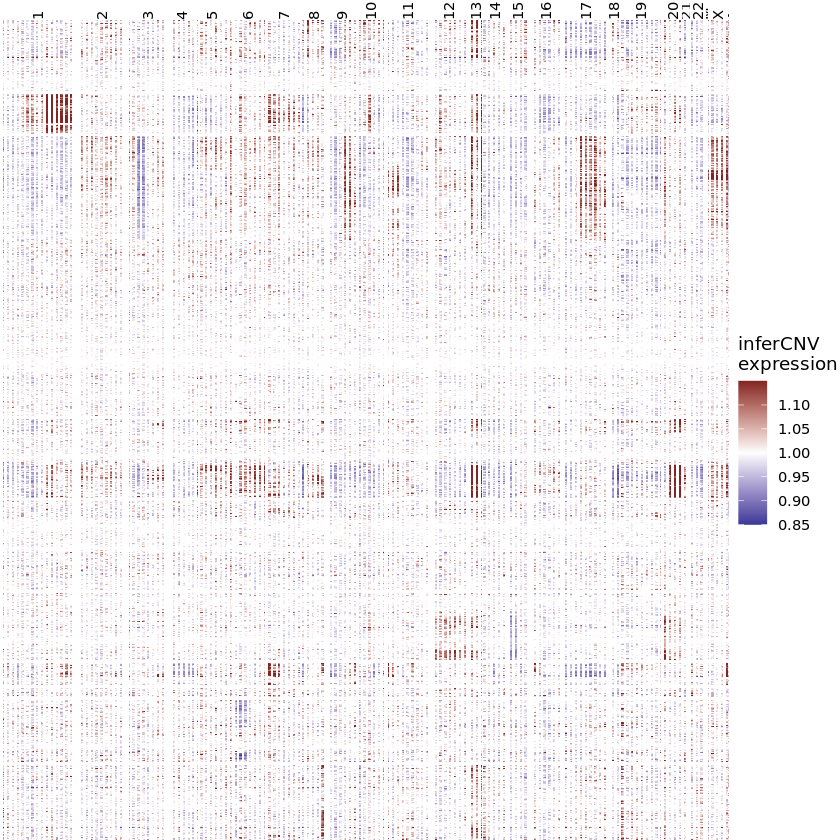

In [92]:
plot_cnv <- ggplot(plot_data) +
  geom_tile(aes(rank, cell_id, fill=value_cut)) +
  theme_void() +
  facet_grid(source_id~chr, scales = "free", space = "free") +
  scale_fill_gradient2(midpoint = 1, low = scales::muted("blue"), high = scales::muted("red")) +
  theme(panel.spacing.x = unit(0, "npc"),
        panel.spacing.y = unit(0.003, "npc"),
        strip.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5),
        strip.text.y = element_blank()) +
  labs(fill = "inferCNV\nexpression")
plot_cnv

In [100]:
cell_type_colors = setNames(c('#999900', '#d6d680', '#336600', '#7c9d5c', '#CCD9BF', '#660099',
       '#990099', '#CC80CC', '#00CCFF', '#0072b1', '#6b9fcb', '#c3c3e0',
       '#AA0000', '#FF0000', '#FF0099', '#EB9999', '#FF9900'),
                           levels(anno_data$cell_type_epi_custom))

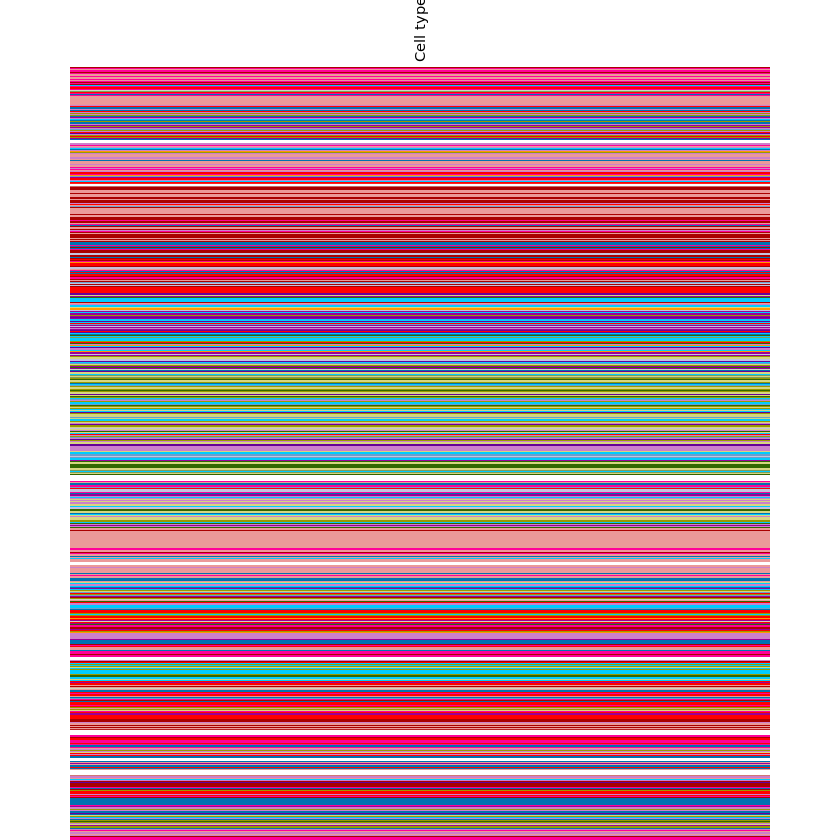

In [101]:
plot_anno_cell <- ggplot(anno_data) +
  geom_tile(aes(helper_var_c, cell_id, fill = cell_type_epi_custom)) +
  theme_void() +
  facet_grid(source_id~helper_var_c, scales = "free", space = "free") +
  scale_fill_manual(values = cell_type_colors) +
  guides(fill = F) +
  theme(panel.spacing.x = unit(0, "npc"),
        panel.spacing.y = unit(0.003, "npc"),
        strip.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5),
        strip.text.y = element_blank()) 
plot_anno_cell

In [103]:
cols.use <- c(
  p001 = '#E69F00', #palette_OkabeIto[1],
  p007 = '#E69F00', #palette_OkabeIto[1],
  p008 = '#56B4E9', #palette_OkabeIto[2],
  p009 = '#009E73', #palette_OkabeIto[3],
  p012 = "#ff0198",
  p013 = '#0072B2', #palette_OkabeIto[5],
  p014 = '#D55E00', #palette_OkabeIto[6],
  p016 = '#CC79A7', #palette_OkabeIto[7],
  p017 = "#451077",
  p020 = "#cccc80",
  p021 = "#FF0000", 
  p025 = "#f6cbcc",
  p026 = "#F0E442",
  CMS1 = "#eba83a", CMS2 = "#027eb5", CMS3 = "#d684ae", CMS4 = "#00a881",
  `CMS1,CMS2` = "#779378", `CMS1,CMS3` = "#E19674", `CMS1,CMS4` = "#76A85E", 
  `CMS2,CMS3` = "#6C81B2", `CMS2,CMS4` = "#01939B",  
  G1 = "#94b6d2",
  S = "#dc4040",
  G2M = "#7aa77f",
  `NA` = "grey",
  Normal = "steelblue",
  Tumor = "red",
  PDO = "steelblue",
  CNA = "red",
  CNN = "grey"
)



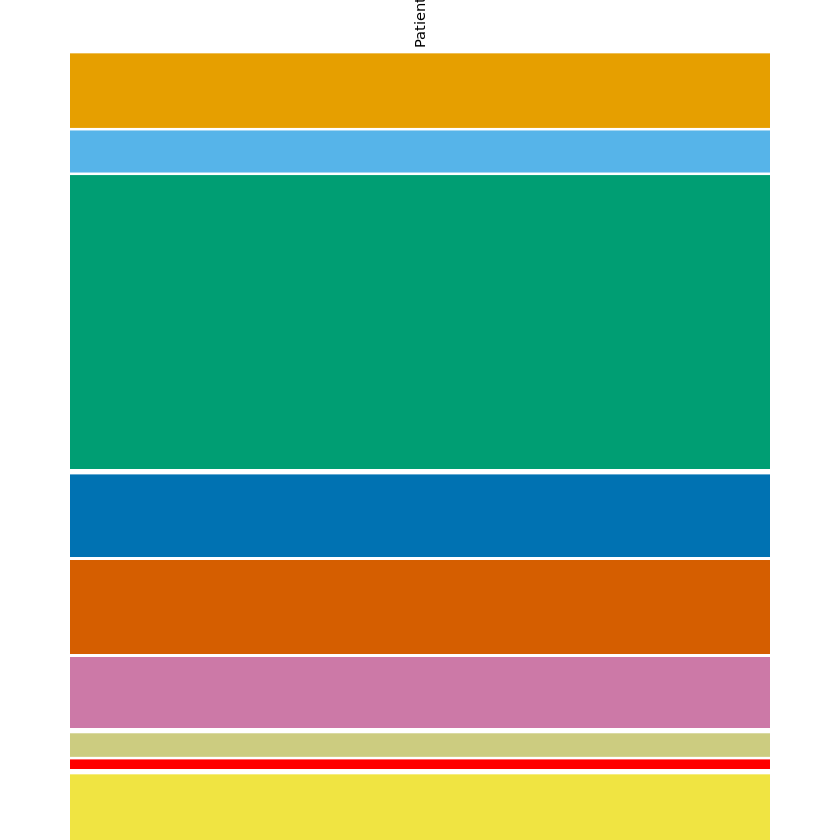

In [104]:
plot_anno_patient <- ggplot(anno_data) +
  geom_tile(aes(helper_var_p, cell_id, fill = source_id)) +
  theme_void() +
  facet_grid(source_id~helper_var_p, scales = "free", space = "free") +
  scale_fill_manual(values = cols.use) +
  guides(fill = F) +
  theme(panel.spacing.x = unit(0, "npc"),
        panel.spacing.y = unit(0.003, "npc"),
        strip.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5),
        strip.text.y = element_blank())
plot_anno_patient

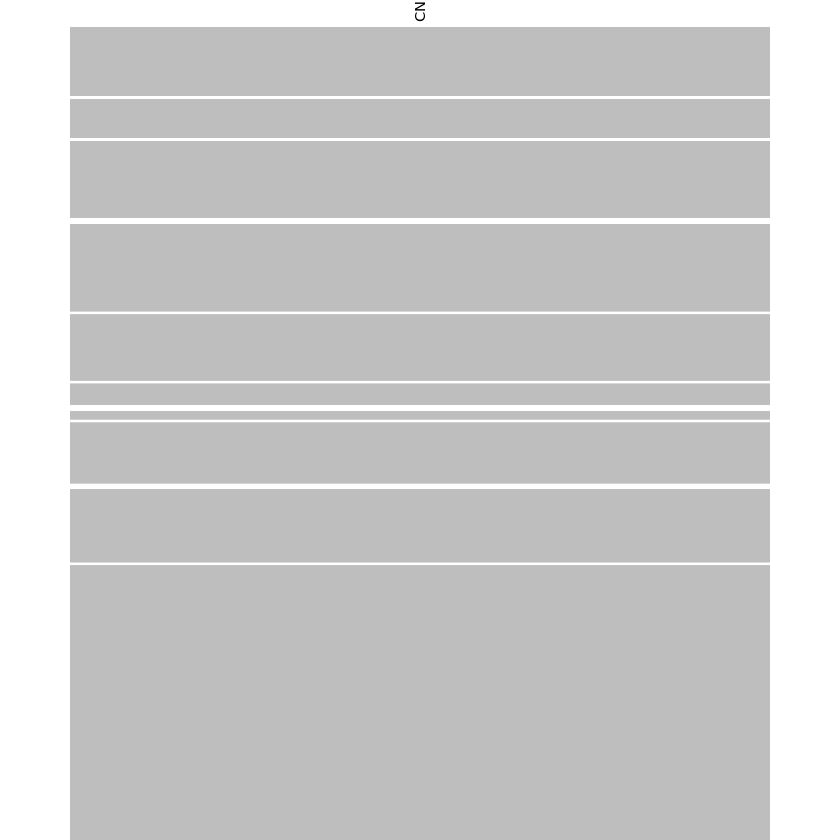

In [105]:
plot_anno_clone <- ggplot(filter(clone_scores, clone != "Normal")) +
  geom_tile(aes(helper_var_c, cell_id, fill = cna_clone)) +
  theme_void() +
  facet_grid(source_id~helper_var_c, scales = "free", space = "free") +
  scale_fill_manual(values = cols.use) +
  guides(fill = F) +
  theme(panel.spacing.x = unit(0, "npc"),
        panel.spacing.y = unit(0.003, "npc"),
        strip.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5),
        strip.text.y = element_blank())
plot_anno_clone

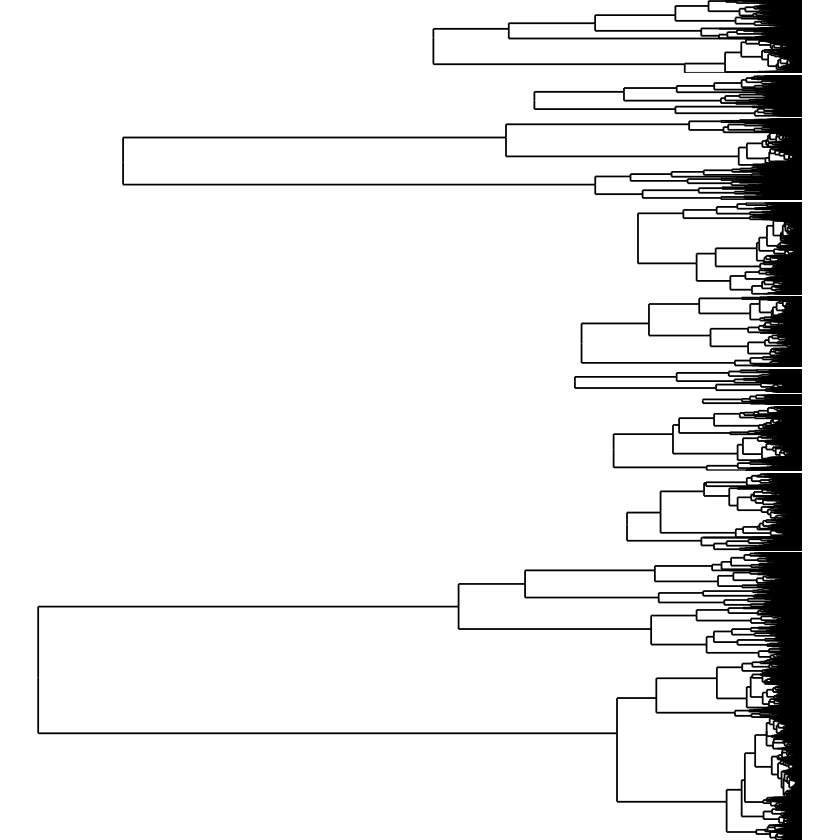

In [106]:
plot_dendro <- ggplot(segments_tbl) +
  geom_segment(aes(x=-y,y=x,xend=-yend,yend=xend),size=0.5) +
  theme_void() +
  facet_grid(source_id~helper_var_d, scales = "free", space = "free") +
  theme(panel.spacing = unit(0, "npc"),
        panel.spacing.x = unit(0, "npc"),
        panel.spacing.y = unit(0.003, "npc"),
        strip.text = element_blank()) +
  scale_y_continuous(expand=c(0,0))
plot_dendro

Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


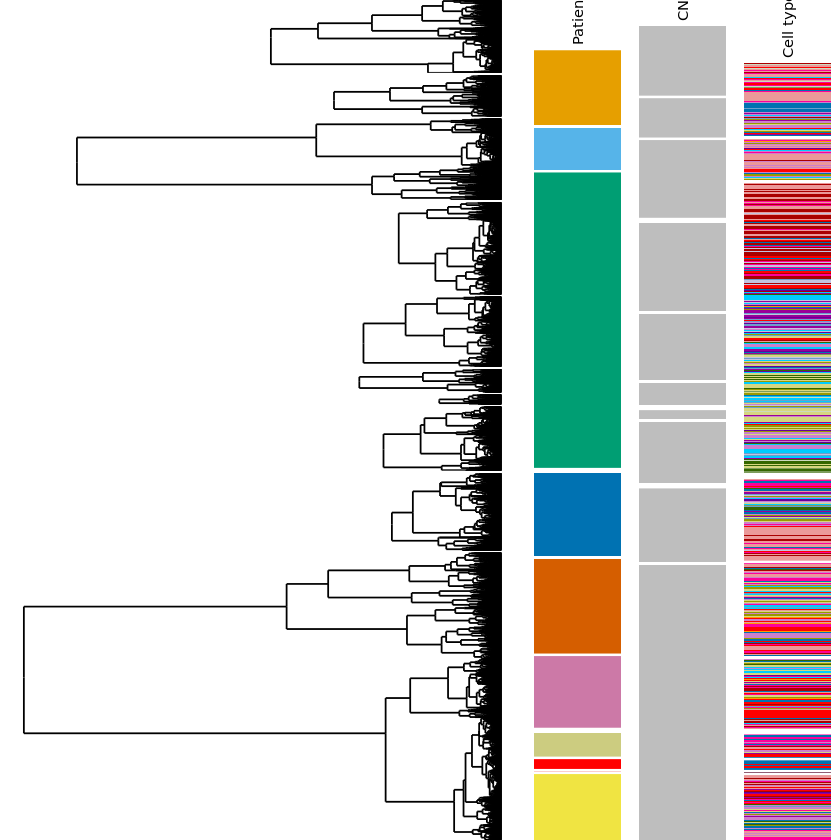

In [109]:
pg_anno <- plot_grid(plot_dendro, plot_anno_patient, plot_anno_clone, plot_anno_cell, 
                     nrow = 1, align = "h", rel_widths = c(0.625, 0.125, 0.125, 0.125))
pg_anno

Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


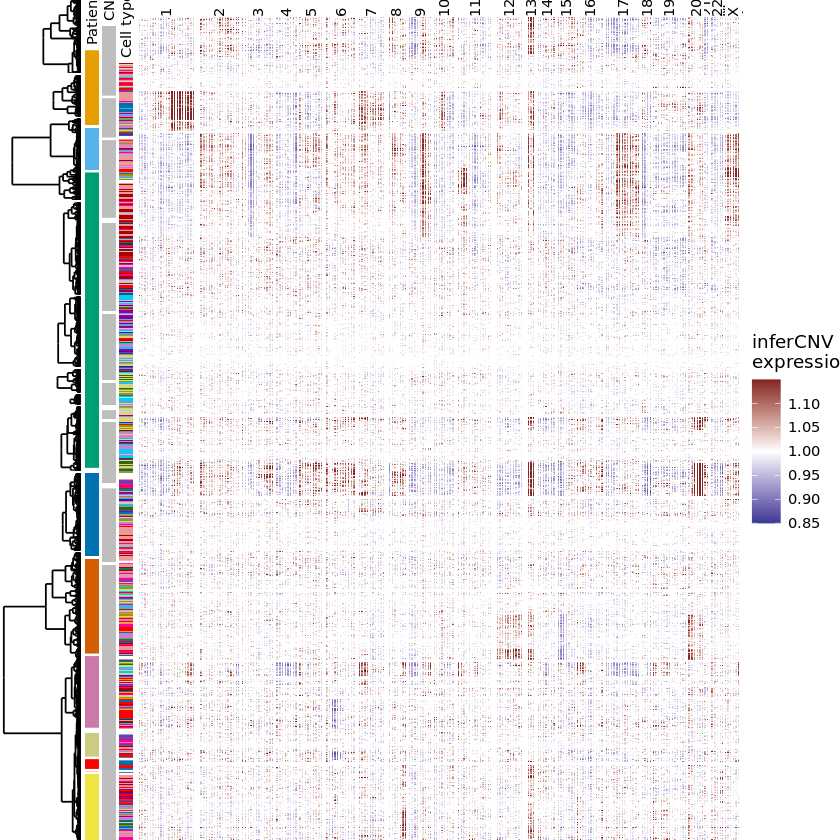

In [110]:
pg <- plot_grid(plot_dendro, plot_anno_patient, plot_anno_clone, plot_anno_cell, plot_cnv, 
                nrow = 1, align = "h", rel_widths = c(0.1, 0.02, 0.02, 0.02, 0.84))
pg

h5closeAll()